# Using Text Data (Pet Descriptions)
Below, we run a Text Only model as well as a Text model unioned with our numerical model.

In [1]:
# Change this depending on where notebook is running
import os
os.chdir('..')

data_loc = "data/"

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

import data
from model import *

Using TensorFlow backend.


In [3]:
# Define data locations
train_images = data_loc + "train_images/*"
test_images = data_loc + "test_images/*"

breed_labels_file = data_loc + "breed_labels.csv"
state_labels_file = data_loc + "state_labels.csv"
color_labels_file = data_loc + "color_labels.csv"

train_file = data_loc + "train/train.csv"
test_file = data_loc + "test/test.csv"

train_sentiment_location = data_loc + "train_sentiment"
test_sentiment_location = data_loc + "test_sentiment"

In [4]:
breed_labels = pd.read_csv(breed_labels_file)
state_labels = pd.read_csv(state_labels_file)
color_labels = pd.read_csv(color_labels_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

### Text Parsing

#### Process sentiment metadata
If the data has already been pre-processed, it will be read from disk.

In [5]:
preprocessed_file = "sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(train_df, train_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    train_df = train_df.merge(sentiment, on='PetID')

preprocessed_file = "test_sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(test_df, test_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    test_df = test_df.merge(sentiment, on='PetID')

#### Parse Description

In [6]:
train_sequence, test_sequence, vocab_len = data.parse_description(train_df, test_df)

In [7]:
train_df['Sequence'] = train_sequence
test_df['Sequence'] = test_sequence

In [8]:
display(train_df[['Sequence']][:10])

,Sequence
0,"[3560, 13317, 10798, 16080, 23444, 20772, 1667..."
1,"[2485, 15913, 42, 12475, 3730, 9985, 15718, 61..."
2,"[4078, 12475, 12775, 23733, 19845, 2119, 3718,..."
3,"[21473, 20294, 6214, 8310, 9221, 19206, 21473,..."
4,"[21483, 23444, 7962, 18430, 17280, 10410, 2363..."
5,"[1347, 5246, 12371, 9041, 20976, 7954, 0, 0, 0..."
6,"[10824, 22497, 8331, 7199, 662, 17203, 14713, ..."
7,"[2119, 3718, 17280, 22497, 2777, 14780, 11083,..."
8,"[11065, 8310, 5958, 5246, 2485, 14612, 227, 10..."
9,"[16259, 12920, 1347, 2485, 11197, 15592, 9278,..."


### Preprocess Numeric Data - One hot encoding

In [9]:
# One hot encode columns
for col, num_class in data.one_hot_cols.items():
    if col is not 'Breed1' and col is not 'Breed2':
        encode = data.one_hot_encode(train_df, col, num_class, inplace=True)
        encode = data.one_hot_encode(test_df, col, num_class, inplace=True)
        print("One hot encoding {} with {} classes...".format(col, num_class))

One hot encoding Type with 2 classes...
One hot encoding Gender with 3 classes...
One hot encoding Color1 with 7 classes...
One hot encoding Color2 with 7 classes...
One hot encoding Color3 with 7 classes...
One hot encoding MaturitySize with 5 classes...
One hot encoding FurLength with 4 classes...
One hot encoding Vaccinated with 3 classes...
One hot encoding Dewormed with 3 classes...
One hot encoding Sterilized with 3 classes...
One hot encoding Health with 4 classes...
One hot encoding State with 15 classes...


In [10]:
# One hot encode y-output
encode = data.one_hot_encode(train_df, 'AdoptionSpeed', inplace=True)

In [11]:
y_col = ['AdoptionSpeed_0', 'AdoptionSpeed_1', 'AdoptionSpeed_2', 'AdoptionSpeed_3', 'AdoptionSpeed_4']

In [12]:
numeric_cols = list(train_df.columns)
numeric_cols.remove("PetID") # String
numeric_cols.remove("Name") # String
numeric_cols.remove("RescuerID") # String
numeric_cols.remove("Description") # String, processed seperately
numeric_cols.remove("Sequence") # processed seperately

for col in y_col:
    numeric_cols.remove(col)

In [13]:
# Testing columns to remove
numeric_cols.remove('Breed1')
numeric_cols.remove('Breed2')

In [14]:
print(numeric_cols)

['Type', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore', 'NumSentences', 'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'Color2_0', 'Color2_2', 'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0', 'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'FurLength_1', 'FurLength_2', 'FurLength_3', 'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health_1', 'Health_2', 'Health_3', 'State_41324', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415']


In [15]:
# Drop any nans
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
# normalize numeric columns
df = train_df[numeric_cols]
train_df[numeric_cols] = (df - df.min()) / (df.max() - df.min())

#### Handle Breeds

In [17]:
# type1_breeds_train_df = train_df[train_df['Type'] == 0] # dogs
# type2_breeds_train_df = train_df[train_df['Type'] == 1] # cats
# print(type1_breeds_train_df.shape)
# print(type2_breeds_train_df.shape)

# type1_breed_labels = breed_labels[breed_labels['Type']==1]
# type2_breed_labels = breed_labels[breed_labels['Type']==2]
# print(type1_breed_labels.shape)
# print(type2_breed_labels.shape)

In [18]:
# # Run One hot encoding on the Breeds
# type1_breed1_onehot = data.one_hot_encode(type1_breeds_train_df, 'Breed1', len(type1_breed_labels),
#                type1_breed_labels['BreedID'])
# type1_breed2_onehot = data.one_hot_encode(type1_breeds_train_df, 'Breed2', len(type1_breed_labels),
#                type1_breed_labels['BreedID'])

# type2_breed1_onehot = data.one_hot_encode(type2_breeds_train_df, 'Breed1', len(type2_breed_labels),
#                type2_breed_labels['BreedID'])
# type2_breed2_onehot = data.one_hot_encode(type2_breeds_train_df, 'Breed2', len(type2_breed_labels),
#                type2_breed_labels['BreedID'])

In [19]:
# # Weights for combining the one hot encodings
# w_breed1 = 1
# w_breed2 = 0.75

# type1_breeds_onehot = w_breed1*type1_breed1_onehot + w_breed2*type1_breed2_onehot
# type2_breeds_onehot = w_breed1*type2_breed1_onehot + w_breed2*type2_breed2_onehot

In [20]:
type1_breeds_pca, type2_breeds_pca, type1_breeds_test_pca, type2_breeds_test_pca = data.parse_breeds(train_df, test_df, breed_labels, [0,0.5])

In [21]:
# from sklearn.decomposition import PCA

# pca1 = PCA(64)
# pca2 = PCA(64)
# type1_breeds_pca = pca1.fit_transform(type1_breeds_onehot)
# type2_breeds_pca = pca2.fit_transform(type2_breeds_onehot)
print(type1_breeds_pca.shape)
print(type2_breeds_pca.shape)

(7439, 64)
(5776, 64)


In [22]:
print(type1_breeds_pca.shape[0] + type2_breeds_pca.shape[0])

13215


In [23]:
train_df.shape

(13215, 77)

In [24]:
# y_type1 = train_df[train_df['Type']==0]
# y_type2 = train_df[train_df['Type']==1]


# type1_y_onehot = data.one_hot_encode(y_type1, 'AdoptionSpeed')
# type2_y_onehot = data.one_hot_encode(y_type2, 'AdoptionSpeed')

### Split into train and validation sets

In [25]:
text_cols = 'Sequence'

In [26]:
# Create a mask for training and validation data
msk1 = np.random.rand(len(train_df[train_df["Type"]==0])) < 0.8
msk2 = np.random.rand(len(train_df[train_df["Type"]==1])) < 0.8

In [27]:
print(len(msk1), len(msk2))

7439 5776


In [28]:
print("Len total:", len(train_df))
print("Len train:" , len(train_df[train_df["Type"]==0][msk1]))
print("Len valid:", len(train_df[train_df["Type"]==0][~msk1]))

Len total: 13215
Len train: 6015
Len valid: 1424


Split into training and validation data


In [29]:
# Text Data
type1_train_x_text = train_df[train_df["Type"]==0][text_cols][msk1]
type1_train_x_text = pd.DataFrame([row for row in type1_train_x_text]) # To make this correct shape

type1_valid_x_text = train_df[train_df["Type"]==0][text_cols][~msk1]
type1_valid_x_text = pd.DataFrame([row for row in type1_valid_x_text])

print("Train x shape {}".format(type1_train_x_text.shape))
print("Valid x shape {}".format(type1_valid_x_text.shape))


# Text Data
type2_train_x_text = train_df[train_df["Type"]==1][text_cols][msk2]
type2_train_x_text = pd.DataFrame([row for row in type2_train_x_text]) # To make this correct shape

type2_valid_x_text = train_df[train_df["Type"]==1][text_cols][~msk2]
type2_valid_x_text = pd.DataFrame([row for row in type2_valid_x_text])

print("Train x shape {}".format(type2_train_x_text.shape))
print("Valid x shape {}".format(type2_valid_x_text.shape))

Train x shape (6015, 30)
Valid x shape (1424, 30)
Train x shape (4637, 30)
Valid x shape (1139, 30)


In [30]:
# Numeric
type1_train_x_num = train_df[train_df["Type"]==0][numeric_cols][msk1]
type1_valid_x_num = train_df[train_df["Type"]==0][numeric_cols][~msk1]

print("Train x shape {}".format(type1_train_x_num.shape))
print("Valid x shape {}".format(type1_valid_x_num.shape))


# Numeric
type2_train_x_num = train_df[train_df["Type"]==1][numeric_cols][msk2]
type2_valid_x_num = train_df[train_df["Type"]==1][numeric_cols][~msk2]

print("Train x shape {}".format(type2_train_x_num.shape))
print("Valid x shape {}".format(type2_valid_x_num.shape))

Train x shape (6015, 65)
Valid x shape (1424, 65)
Train x shape (4637, 65)
Valid x shape (1139, 65)


In [31]:
# Breeds
type1_train_x_breed = type1_breeds_pca[msk1]
type1_valid_x_breed = type1_breeds_pca[~msk1]

print("Train x shape {}".format(type1_train_x_breed.shape))
print("Valid x shape {}".format(type1_valid_x_breed.shape))

type2_train_x_breed = type2_breeds_pca[msk2]
type2_valid_x_breed = type2_breeds_pca[~msk2]

print("Train x shape {}".format(type2_train_x_breed.shape))
print("Valid x shape {}".format(type2_valid_x_breed.shape))

Train x shape (6015, 64)
Valid x shape (1424, 64)
Train x shape (4637, 64)
Valid x shape (1139, 64)


In [32]:
# The y's are the same for both text and numerical models
type1_train_y = train_df[train_df["Type"]==0][y_col][msk1]
type1_valid_y = train_df[train_df["Type"]==0][y_col][~msk1]


# The y's are the same for both text and numerical models
type2_train_y = train_df[train_df["Type"]==1][y_col][msk2]
type2_valid_y = train_df[train_df["Type"]==1][y_col][~msk2]

## Text Only Model
Defined in model.py as TextOnlyModel

#### Type 1

In [33]:
type1_text_model = TextOnlyModel((type1_train_x_text, type1_train_y),
                           (type1_valid_x_text, type1_valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [34]:
type1_text_model.compile()
type1_text_model.train(epochs=10)

Train on 6015 samples, validate on 1424 samples
Epoch 1/10
6015/6015 [==============================] - 25s 4ms/step - loss: 1.4678 - acc: 0.2786 - val_loss: 1.4289 - val_acc: 0.2992
Epoch 2/10
6015/6015 [==============================] - 18s 3ms/step - loss: 1.3980 - acc: 0.3594 - val_loss: 1.3902 - val_acc: 0.3813
Epoch 3/10
6015/6015 [==============================] - 19s 3ms/step - loss: 1.2834 - acc: 0.4284 - val_loss: 1.4136 - val_acc: 0.3617
Epoch 4/10
6015/6015 [==============================] - 19s 3ms/step - loss: 1.1889 - acc: 0.4768 - val_loss: 1.5265 - val_acc: 0.3624
Epoch 5/10
6015/6015 [==============================] - 18s 3ms/step - loss: 1.1204 - acc: 0.5165 - val_loss: 1.6028 - val_acc: 0.3511
Epoch 6/10
6015/6015 [==============================] - 18s 3ms/step - loss: 1.0548 - acc: 0.5488 - val_loss: 1.6420 - val_acc: 0.3567
Epoch 7/10
6015/6015 [==============================] - 18s 3ms/step - loss: 1.0052 - acc: 0.5832 - val_loss: 1.6615 - val_acc: 0.3855
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


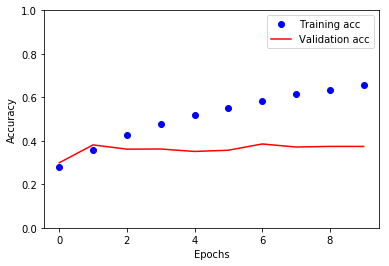

In [35]:
history = type1_text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

#### Type 2

In [36]:
type2_train_x_text

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,3560.0,13317.0,10798.0,16080.0,23444.0,20772.0,16672.0,6767.0,3560.0,15710.0,...,14710.0,1365.0,6767.0,11886.0,24579.0,2533.0,9198.0,14821.0,23636.0,1365.0
1,2485.0,15913.0,42.0,12475.0,3730.0,9985.0,15718.0,6115.0,24690.0,8753.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10824.0,22497.0,8331.0,7199.0,662.0,17203.0,14713.0,12004.0,19265.0,10639.0,...,6767.0,9041.0,11896.0,23433.0,2102.0,21473.0,16342.0,2119.0,21473.0,6978.0
3,16259.0,12920.0,1347.0,2485.0,11197.0,15592.0,9278.0,2485.0,6115.0,7954.0,...,8331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9736.0,22973.0,24134.0,5450.0,17162.0,11197.0,13371.0,9041.0,15913.0,3832.0,...,2784.0,12741.0,24579.0,21473.0,3782.0,6115.0,9249.0,20322.0,12741.0,2537.0
5,6767.0,9782.0,3381.0,23039.0,16621.0,16259.0,19292.0,5246.0,4483.0,5102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,20890.0,23591.0,24262.0,3467.0,11401.0,6036.0,20535.0,16635.0,22760.0,8331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5246.0,2485.0,4078.0,13213.0,7954.0,22298.0,23877.0,9278.0,12027.0,20811.0,...,18997.0,14821.0,5246.0,16382.0,23038.0,3560.0,19569.0,3560.0,0.0,0.0
8,4436.0,21483.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,12004.0,12449.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
type2_text_model = TextOnlyModel((type2_train_x_text, type2_train_y),
                           (type2_valid_x_text, type2_valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [38]:
type2_text_model.compile()
type2_text_model.train(epochs=10)

Train on 4637 samples, validate on 1139 samples
Epoch 1/10
4637/4637 [==============================] - 19s 4ms/step - loss: 1.5112 - acc: 0.2704 - val_loss: 1.4756 - val_acc: 0.2564
Epoch 2/10
4637/4637 [==============================] - 14s 3ms/step - loss: 1.4694 - acc: 0.2995 - val_loss: 1.4655 - val_acc: 0.2818
Epoch 3/10
4637/4637 [==============================] - 14s 3ms/step - loss: 1.3518 - acc: 0.3893 - val_loss: 1.5690 - val_acc: 0.2730
Epoch 4/10
4637/4637 [==============================] - 15s 3ms/step - loss: 1.1848 - acc: 0.4818 - val_loss: 1.6184 - val_acc: 0.2880
Epoch 5/10
4637/4637 [==============================] - 16s 3ms/step - loss: 1.0220 - acc: 0.5527 - val_loss: 1.8091 - val_acc: 0.2871
Epoch 6/10
4637/4637 [==============================] - 16s 3ms/step - loss: 0.9262 - acc: 0.5896 - val_loss: 2.0036 - val_acc: 0.2941
Epoch 7/10
4637/4637 [==============================] - 14s 3ms/step - loss: 0.8625 - acc: 0.6202 - val_loss: 2.0116 - val_acc: 0.2915
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


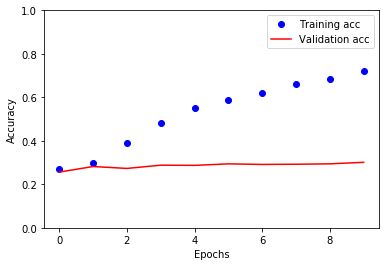

In [39]:
history = type2_text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import accuracy_score
type1_pred_on_type2_model = type2_text_model.predict(type1_valid_x_text)
type1_pred_on_type2_model = np.argmax(type1_pred_on_type2_model, -1)

y_true_test = np.argmax(np.array(type1_valid_y), -1)
accuracy_score(y_true_test, type1_pred_on_type2_model)

0.288623595505618

## Numerical Model

In [41]:
class ImageFreeModel(KaggleModel):
    def __init__(self, train, test, shape):
        kernel = Sequential(name='image_free_encoder')
        
        kernel.add(BatchNormalization(input_shape=(shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Activation('relu'))
        
        kernel.add(Dense(64, activation='relu'))
        
        kernel.add(Dense(32, activation='relu'))

        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='image_free')
        model.add(kernel)
        
        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
type1_numerical_model = ImageFreeModel((type1_train_x_num, type1_train_y),
                                 (type1_valid_x_num, type1_valid_y),
                                 type1_train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [43]:
type1_numerical_model.compile()
type1_numerical_model.train(epochs=10)

Train on 6015 samples, validate on 1424 samples
Epoch 1/10
6015/6015 [==============================] - 3s 473us/step - loss: 1.4304 - acc: 0.3272 - val_loss: 1.4056 - val_acc: 0.3596
Epoch 2/10
6015/6015 [==============================] - 1s 123us/step - loss: 1.3644 - acc: 0.3820 - val_loss: 1.3825 - val_acc: 0.3736
Epoch 3/10
6015/6015 [==============================] - 1s 125us/step - loss: 1.3356 - acc: 0.4032 - val_loss: 1.3973 - val_acc: 0.3806
Epoch 4/10
6015/6015 [==============================] - 1s 125us/step - loss: 1.3094 - acc: 0.4213 - val_loss: 1.4065 - val_acc: 0.3757
Epoch 5/10
6015/6015 [==============================] - 1s 127us/step - loss: 1.2884 - acc: 0.4298 - val_loss: 1.4179 - val_acc: 0.3750
Epoch 6/10
6015/6015 [==============================] - 1s 125us/step - loss: 1.2657 - acc: 0.4477 - val_loss: 1.4305 - val_acc: 0.3708
Epoch 7/10
6015/6015 [==============================] - 1s 123us/step - loss: 1.2474 - acc: 0.4585 - val_loss: 1.4585 - val_acc: 0.3715


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


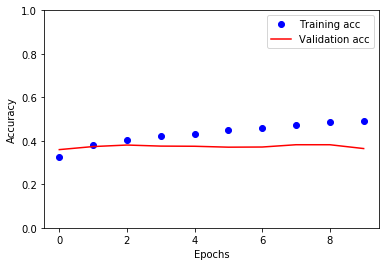

In [44]:
history = type1_numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [45]:
type2_numerical_model = ImageFreeModel((type2_train_x_num, type2_train_y),
                                 (type2_valid_x_num, type2_valid_y),
                                 type2_train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [46]:
type2_numerical_model.compile()
type2_numerical_model.train(epochs=10)

Train on 4637 samples, validate on 1139 samples
Epoch 1/10
4637/4637 [==============================] - 3s 567us/step - loss: 1.4775 - acc: 0.3194 - val_loss: 1.4362 - val_acc: 0.3363
Epoch 2/10
4637/4637 [==============================] - 1s 124us/step - loss: 1.4046 - acc: 0.3683 - val_loss: 1.4204 - val_acc: 0.3573
Epoch 3/10
4637/4637 [==============================] - 1s 122us/step - loss: 1.3727 - acc: 0.3929 - val_loss: 1.4171 - val_acc: 0.3696
Epoch 4/10
4637/4637 [==============================] - 1s 127us/step - loss: 1.3456 - acc: 0.4033 - val_loss: 1.4269 - val_acc: 0.3573
Epoch 5/10
4637/4637 [==============================] - 1s 128us/step - loss: 1.3189 - acc: 0.4251 - val_loss: 1.4394 - val_acc: 0.3565
Epoch 6/10
4637/4637 [==============================] - 1s 132us/step - loss: 1.2938 - acc: 0.4380 - val_loss: 1.4556 - val_acc: 0.3503
Epoch 7/10
4637/4637 [==============================] - 1s 135us/step - loss: 1.2638 - acc: 0.4499 - val_loss: 1.4787 - val_acc: 0.3556


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


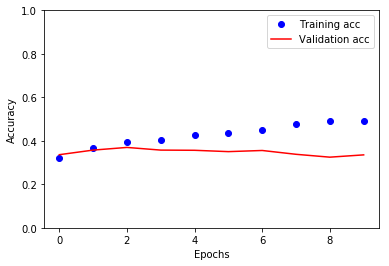

In [47]:
history = type2_numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Union Model - Text + Num
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [48]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:
type1_union_model = UnionModel2([type1_text_model, type1_numerical_model],
                         ([type1_train_x_text, type1_train_x_num], type1_train_y),
                         ([type1_valid_x_text, type1_valid_x_num], type1_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [50]:
type1_union_model.compile()
type1_union_model.train(epochs=10)

Train on 6015 samples, validate on 1424 samples
Epoch 1/10
6015/6015 [==============================] - 9s 1ms/step - loss: 0.7441 - acc: 0.7244 - val_loss: 2.5066 - val_acc: 0.3785
Epoch 2/10
6015/6015 [==============================] - 3s 561us/step - loss: 0.6873 - acc: 0.7441 - val_loss: 2.2089 - val_acc: 0.3694
Epoch 3/10
6015/6015 [==============================] - 3s 550us/step - loss: 0.6746 - acc: 0.7408 - val_loss: 2.3490 - val_acc: 0.3722
Epoch 4/10
6015/6015 [==============================] - 3s 548us/step - loss: 0.6606 - acc: 0.7425 - val_loss: 2.1073 - val_acc: 0.3624
Epoch 5/10
6015/6015 [==============================] - 3s 548us/step - loss: 0.6646 - acc: 0.7436 - val_loss: 2.0719 - val_acc: 0.3855
Epoch 6/10
6015/6015 [==============================] - 4s 650us/step - loss: 0.6526 - acc: 0.7506 - val_loss: 2.0996 - val_acc: 0.3799
Epoch 7/10
6015/6015 [==============================] - 4s 610us/step - loss: 0.6536 - acc: 0.7493 - val_loss: 1.9955 - val_acc: 0.3687
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


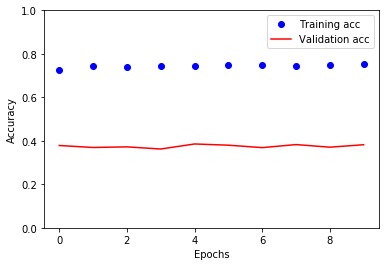

In [51]:
history = type1_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [52]:
type2_union_model = UnionModel2([type2_text_model, type2_numerical_model],
                         ([type2_train_x_text, type2_train_x_num], type2_train_y),
                         ([type2_valid_x_text, type2_valid_x_num], type2_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [53]:
type2_union_model.compile()
type2_union_model.train(epochs=10)

Train on 4637 samples, validate on 1139 samples
Epoch 1/10
4637/4637 [==============================] - 9s 2ms/step - loss: 0.6033 - acc: 0.7733 - val_loss: 3.0476 - val_acc: 0.3134
Epoch 2/10
4637/4637 [==============================] - 4s 758us/step - loss: 0.5204 - acc: 0.7990 - val_loss: 3.2595 - val_acc: 0.3284
Epoch 3/10
4637/4637 [==============================] - 4s 797us/step - loss: 0.5192 - acc: 0.7947 - val_loss: 2.9765 - val_acc: 0.3398
Epoch 4/10
4637/4637 [==============================] - 4s 760us/step - loss: 0.4958 - acc: 0.8139 - val_loss: 3.0333 - val_acc: 0.3310
Epoch 5/10
4637/4637 [==============================] - 3s 710us/step - loss: 0.5009 - acc: 0.8102 - val_loss: 2.9430 - val_acc: 0.3292
Epoch 6/10
4637/4637 [==============================] - 3s 724us/step - loss: 0.4879 - acc: 0.8169 - val_loss: 2.7447 - val_acc: 0.3301
Epoch 7/10
4637/4637 [==============================] - 3s 731us/step - loss: 0.4833 - acc: 0.8154 - val_loss: 2.8900 - val_acc: 0.3301
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


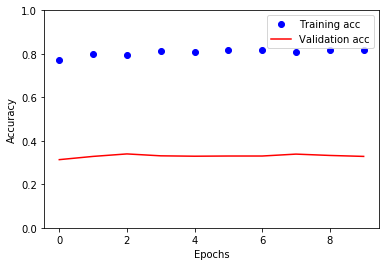

In [54]:
history = type2_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Breeds Model

In [55]:
class BreedModel(KaggleModel):
    def __init__(self, train, test, input_shape=64):
        kernel = Sequential(name='breeds_encoder')
        
        kernel.add(BatchNormalization(input_shape=(input_shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Dense(128))
        
        kernel.add(Dense(64))
        kernel.add(Dense(64))

        kernel.add(Dense(32))
        kernel.add(Dense(32))
        
        
        kernel.add(Activation('relu'))
        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='breed')
        model.add(kernel)
        
        model.add(Dense(64, activation='relu'))

        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)
    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
type1_breeds_model = BreedModel((type1_train_x_breed, type1_train_y),
                                 (type1_valid_x_breed, type1_valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                40640     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 325       
Total params: 43,077
Trainable params: 42,949
Non-trainable params: 128
_________________________________________________________________


In [57]:
type1_breeds_model.compile()
type1_breeds_model.train(epochs=10)

Train on 6015 samples, validate on 1424 samples
Epoch 1/10
6015/6015 [==============================] - 6s 941us/step - loss: 1.4767 - acc: 0.2889 - val_loss: 1.4468 - val_acc: 0.2563
Epoch 2/10
6015/6015 [==============================] - 1s 247us/step - loss: 1.4459 - acc: 0.2936 - val_loss: 1.4557 - val_acc: 0.3090
Epoch 3/10
6015/6015 [==============================] - 1s 206us/step - loss: 1.4430 - acc: 0.2974 - val_loss: 1.4449 - val_acc: 0.2942
Epoch 4/10
6015/6015 [==============================] - 1s 166us/step - loss: 1.4382 - acc: 0.2886 - val_loss: 1.4565 - val_acc: 0.3069
Epoch 5/10
6015/6015 [==============================] - 1s 180us/step - loss: 1.4381 - acc: 0.2918 - val_loss: 1.4547 - val_acc: 0.2718
Epoch 6/10
6015/6015 [==============================] - 1s 201us/step - loss: 1.4351 - acc: 0.2989 - val_loss: 1.4507 - val_acc: 0.2704
Epoch 7/10
6015/6015 [==============================] - 1s 173us/step - loss: 1.4352 - acc: 0.2901 - val_loss: 1.4566 - val_acc: 0.3041


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


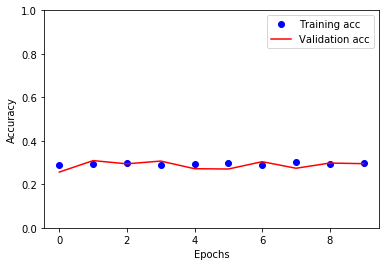

In [58]:
history = type1_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [59]:
type2_breeds_model = BreedModel((type2_train_x_breed, type2_train_y),
                                 (type2_valid_x_breed, type2_valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                40640     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 325       
Total params: 43,077
Trainable params: 42,949
Non-trainable params: 128
_________________________________________________________________


In [60]:
type2_breeds_model.compile()
type2_breeds_model.train(epochs=10)

Train on 4637 samples, validate on 1139 samples
Epoch 1/10
4637/4637 [==============================] - 6s 1ms/step - loss: 1.5109 - acc: 0.2696 - val_loss: 1.5251 - val_acc: 0.2651
Epoch 2/10
4637/4637 [==============================] - 1s 178us/step - loss: 1.4869 - acc: 0.2810 - val_loss: 1.5038 - val_acc: 0.2608
Epoch 3/10
4637/4637 [==============================] - 1s 188us/step - loss: 1.4825 - acc: 0.2771 - val_loss: 1.4994 - val_acc: 0.2581
Epoch 4/10
4637/4637 [==============================] - 1s 200us/step - loss: 1.4809 - acc: 0.2834 - val_loss: 1.5014 - val_acc: 0.2608
Epoch 5/10
4637/4637 [==============================] - 1s 177us/step - loss: 1.4761 - acc: 0.2834 - val_loss: 1.5141 - val_acc: 0.2520
Epoch 6/10
4637/4637 [==============================] - 1s 183us/step - loss: 1.4775 - acc: 0.2840 - val_loss: 1.5114 - val_acc: 0.2590
Epoch 7/10
4637/4637 [==============================] - 1s 178us/step - loss: 1.4748 - acc: 0.2873 - val_loss: 1.5208 - val_acc: 0.2502
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


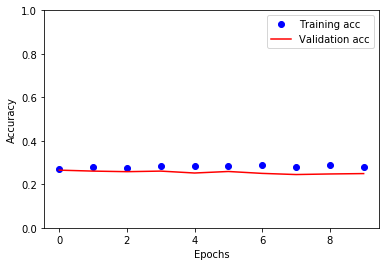

In [61]:
history = type2_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Union Model - Text + Num + Breeds
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [62]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dropout(0.5)(y)
        y = Dense(128)(y)
#         y = Dropout(0.5)(y)
        y = Dense(64)(y)
#         y = Dropout(0.5)(y)
        y = Dense(64)(y)
#         y = Dropout(0.5)(y)
        y = Dense(32)(y)
        y = Dense(32)(y)
        
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [63]:
type1_union_model = UnionModel2([type1_text_model, type1_numerical_model, type1_breeds_model],
                         ([type1_train_x_text, type1_train_x_num, type1_train_x_breed], type1_train_y),
                         ([type1_valid_x_text, type1_valid_x_num, type1_valid_x_breed], type1_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
breed_in (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free

In [64]:
type1_union_model.compile()
type1_union_model.train(epochs=50)

Train on 6015 samples, validate on 1424 samples
Epoch 1/50
6015/6015 [==============================] - 10s 2ms/step - loss: 0.8129 - acc: 0.6838 - val_loss: 2.1347 - val_acc: 0.3792
Epoch 2/50
6015/6015 [==============================] - 6s 945us/step - loss: 0.7321 - acc: 0.7249 - val_loss: 2.1851 - val_acc: 0.3673
Epoch 3/50
6015/6015 [==============================] - 4s 620us/step - loss: 0.6981 - acc: 0.7380 - val_loss: 2.2333 - val_acc: 0.3862
Epoch 4/50
6015/6015 [==============================] - 5s 868us/step - loss: 0.6826 - acc: 0.7363 - val_loss: 2.2229 - val_acc: 0.3883
Epoch 5/50
6015/6015 [==============================] - 4s 746us/step - loss: 0.6836 - acc: 0.7388 - val_loss: 2.0810 - val_acc: 0.3855
Epoch 6/50
6015/6015 [==============================] - 4s 737us/step - loss: 0.6805 - acc: 0.7387 - val_loss: 2.2078 - val_acc: 0.3806
Epoch 7/50
6015/6015 [==============================] - 5s 760us/step - loss: 0.6879 - acc: 0.7388 - val_loss: 2.1307 - val_acc: 0.3799
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


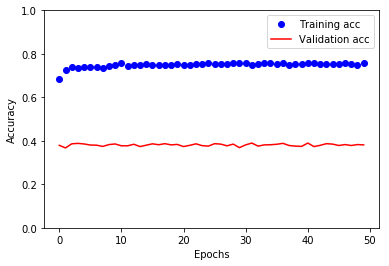

In [65]:
history = type1_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [66]:
type2_union_model = UnionModel2([type2_text_model, type2_numerical_model, type2_breeds_model],
                         ([type2_train_x_text, type2_train_x_num, type2_train_x_breed], type2_train_y),
                         ([type2_valid_x_text, type2_valid_x_num, type2_valid_x_breed], type2_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
breed_in (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free

In [67]:
type2_union_model.compile()
type2_union_model.train(epochs=10)

Train on 4637 samples, validate on 1139 samples
Epoch 1/10
4637/4637 [==============================] - 8s 2ms/step - loss: 0.7191 - acc: 0.7276 - val_loss: 2.5165 - val_acc: 0.3231
Epoch 2/10
4637/4637 [==============================] - 3s 601us/step - loss: 0.5802 - acc: 0.7802 - val_loss: 2.6696 - val_acc: 0.3266
Epoch 3/10
4637/4637 [==============================] - 3s 606us/step - loss: 0.5523 - acc: 0.7971 - val_loss: 2.6359 - val_acc: 0.3319
Epoch 4/10
4637/4637 [==============================] - 3s 584us/step - loss: 0.5370 - acc: 0.7992 - val_loss: 2.7559 - val_acc: 0.3345
Epoch 5/10
4637/4637 [==============================] - 3s 592us/step - loss: 0.5264 - acc: 0.7999 - val_loss: 2.7432 - val_acc: 0.3248
Epoch 6/10
4637/4637 [==============================] - 3s 617us/step - loss: 0.5303 - acc: 0.7994 - val_loss: 2.6707 - val_acc: 0.3231
Epoch 7/10
4637/4637 [==============================] - 3s 606us/step - loss: 0.5056 - acc: 0.8087 - val_loss: 2.6844 - val_acc: 0.3336
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


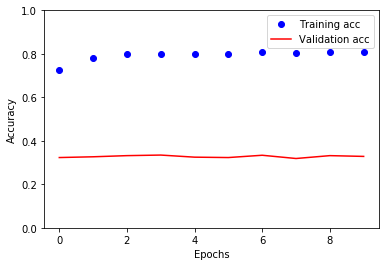

In [68]:
history = type2_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [69]:
# TODO replace this with test values!

Y = type2_union_model.predict([type2_train_x_text, type2_train_x_num, type2_train_x_breed])
Y = np.argmax(Y, -1)

In [70]:
Y

array([2, 3, 1, ..., 4, 4, 4])

In [71]:
train_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Quantity', 'Fee',
       'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt',
       'SentimentMagnitude', 'SentimentScore', 'NumSentences', 'Sequence',
       'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1', 'Color1_2', 'Color1_3',
       'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'Color2_0', 'Color2_2',
       'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0',
       'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7',
       'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4',
       'FurLength_1', 'FurLength_2', 'FurLength_3', 'Vaccinated_1',
       'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2',
       'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3',
       'Health_1', 'Health_2', 'Health_3', 'State_41324', 'State_41325',
       'State_41326', 'State_41327', 'State_41330', 'State_41332',
       'State_41335', 'State_41336', 'State_41342', 'State_41